# S&P 500: Classification problem with DT, RF, and NN

In [1]:
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings(action = 'ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['axes.unicode_minus'] = False

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import plot_confusion_matrix
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

In [75]:
snp=pd.read_csv('2001final.csv')
snp.head()

,Name,R,OI,NI,Asset,Equity,Debt,FCFF,g,Tech,...,Mkt,TEV,d,PER,PSR,PBR,EV/EBITDA,CAPEX,EBITDA,Survival
0,Edison International,11062.0,5076.0,1035.0,36774.0,4001.0,17567.0,3550.500,9.7969,0,...,4919.749211,21916.749210,5.5629,4.753381,0.444743,0.133783,3.625600,933.0,6045.0,1
1,Barrick Gold Corp,1989.0,219.0,96.0,5202.0,3192.0,802.0,96.250,-1.6668,0,...,6328.540031,6349.371239,1.3766,65.922292,3.181770,1.216559,8.818571,474.0,720.0,0
2,Verizon Communications Inc,66713.0,13994.0,389.0,170795.0,54688.0,64326.0,1339.750,7.0696,0,...,128828.004700,213004.004700,3.2448,331.177390,1.931078,0.754284,7.740815,18369.0,27517.0,0
3,Boeing Co/The,58198.0,4407.0,2827.0,48978.0,10825.0,12265.0,4254.625,0.1765,0,...,30945.364010,41042.364010,1.7534,10.946362,0.531726,0.631822,6.673555,1189.0,6150.0,1
4,Chevron Corp,97863.0,8972.0,3288.0,77572.0,34241.0,17418.0,696.875,12.4228,0,...,57572.843200,59048.843200,2.9014,17.509989,0.588300,0.742186,3.683416,9713.0,16031.0,1


In [4]:
snp = snp.replace({'na':np.nan})
snp = snp.dropna()
print(snp.shape)

(386, 22)


In [7]:
X = snp.iloc[:,1:-1]
y = snp.iloc[:,-1]
features = X.columns.tolist()
print(features)

['R', 'OI', 'NI', 'Asset', 'Equity', 'Debt', 'FCFF', 'g', 'Tech', 'old', 'US', 'Mkt', 'TEV', 'd', 'PER', 'PSR', 'PBR', 'EV/EBITDA', 'CAPEX', 'EBITDA']


In [17]:
y.value_counts()

0    282
1    104
Name: Survival, dtype: int64

In [18]:
X = MinMaxScaler().fit_transform(X)

{'max_depth': range(3, 500)}
DecisionTreeClassifier(max_depth=3)
[0.02632693 0.         0.40296842 0.         0.         0.
 0.         0.14297256 0.         0.         0.         0.
 0.16106105 0.15326185 0.         0.         0.         0.11340919
 0.         0.        ]


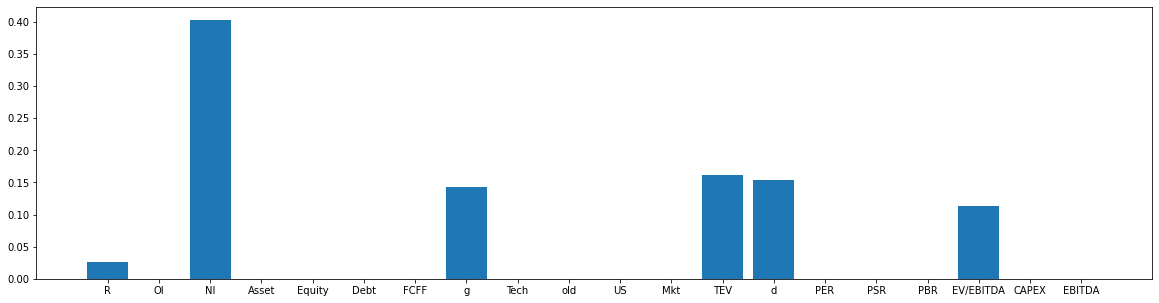

In [12]:
parameters = {'max_depth':range(3,500)}
print(parameters)
Mdls = GridSearchCV(tree.DecisionTreeClassifier(),parameters, n_jobs=4)
Mdls = Mdls.fit(X, y)
Mdl = Mdls.best_estimator_
print(Mdl)
imp = Mdl.feature_importances_

I = np.arange(imp.shape[0])
plt.subplots(1, figsize=(20, 5))
plt.bar(I,imp)
plt.xticks(I,features);
best_param = Mdl.get_params()
best_param
print(imp)

In [21]:
pred = Mdl.predict(X)
accuracy = np.mean(pred==y)
accuracy

0.7642487046632125

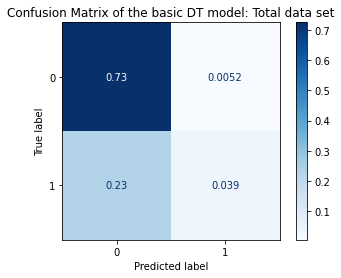

In [47]:
plot_confusion_matrix(Mdl, X, y, normalize = 'all', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of the basic DT model: Total data set')
plt.show()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rfc = RandomForestClassifier(n_estimators = 10, random_state = 2021)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=2021)

In [29]:
y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred = y_pred)
print("The performance of basic model to train set")
print(f"accuracy: {acc:0.4f}")

y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred = y_pred)
print("The performance of basic model to test set")
print(f"accuracy: {acc:0.4f}")

The performance of basic model to train set
accuracy: 0.9667
The performance of basic model to test set
accuracy: 0.6552


100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


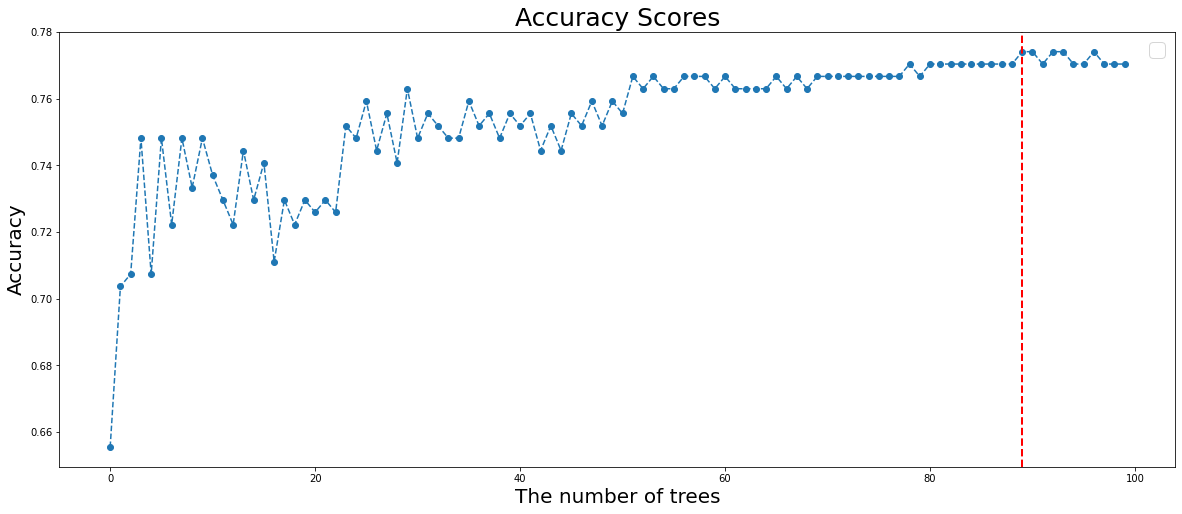

In [30]:
cv_scores = []
estimator_list = [i for i in range(0,100,1)]
for i in tqdm(range(0,100,1)):
    rfc = RandomForestClassifier(n_estimators = i+1,
                                 n_jobs = -1, random_state = 2021)
    score = cross_val_score(rfc, X_train, y_train, cv=10, scoring = 'accuracy').mean()
    cv_scores.append(score)

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
plt.figure(figsize = (20,8))
plt.legend(["Cross valid1ation scores"], fontsize = 20)
plt.plot(estimator_list, cv_scores, marker = 'o', linestyle = 'dashed')
plt.xlabel("The number of trees", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Accuracy Scores", fontsize = 25)
plt.axvline(best_e[0], color='r', linestyle = '--', linewidth=2)
plt.show()

In [31]:
print(f"the performance is the best when the number of tree is {(cv_scores.index(max(cv_scores)))+1}")
print("The performance(10 fold cross validation)")
print(f"Accuracy: {max(cv_scores): 0.4f}")

the performance is the best when the number of tree is 90
The performance(10 fold cross validation)
Accuracy:  0.7741


In [33]:
rfc = RandomForestClassifier(n_estimators = 90, random_state = 2021)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred = y_pred)
print("The performance of adjusted model to train set")
print(f"accuracy: {acc:0.4f}")

y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred = y_pred)
print("The performance of adjusted model to test set")
print(f"accuracy: {acc:0.4f}")

The performance of adjusted model to train set
accuracy: 0.9963
The performance of adjusted model to test set
accuracy: 0.6638


In [34]:
rfc_score = pd.DataFrame(cv_scores, columns = ['accuracy'])
rfc_score['accu_rank'] = rfc_score['accuracy'].rank(ascending = 0)
rfc_score = rfc_score.sort_values(by=['accu_rank'])
rfc_score.head()

,accuracy,accu_rank
96,0.774074,3.0
93,0.774074,3.0
92,0.774074,3.0
90,0.774074,3.0
89,0.774074,3.0


In [35]:
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators' : [97, 94, 93, 91, 90],
    'max_depth' : [10, 15, 20, 25],
    'max_leaf_nodes' : [25, 30, 35],
    'criterion' : ['gini', 'entropy']
    # 'max_features' : ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv=10, verbose = 1, n_jobs=-1)
CV_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25],
                         'max_leaf_nodes': [25, 30, 35],
                         'n_estimators': [97, 94, 93, 91, 90]},
             verbose=1)

In [36]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'max_leaf_nodes': 35,
 'n_estimators': 94}

In [37]:
result_table = pd.DataFrame(CV_rfc.cv_results_)
result_table = result_table.sort_values(by = 'mean_test_score', ascending = False)
print(result_table[['params', 'mean_test_score']])

                                                params  mean_test_score
56   {'criterion': 'gini', 'max_depth': 25, 'max_le...         0.777778
109  {'criterion': 'entropy', 'max_depth': 25, 'max...         0.777778
116  {'criterion': 'entropy', 'max_depth': 25, 'max...         0.774074
4    {'criterion': 'gini', 'max_depth': 10, 'max_le...         0.774074
89   {'criterion': 'entropy', 'max_depth': 15, 'max...         0.774074
..                                                 ...              ...
94   {'criterion': 'entropy', 'max_depth': 20, 'max...         0.744444
30   {'criterion': 'gini', 'max_depth': 20, 'max_le...         0.740741
21   {'criterion': 'gini', 'max_depth': 15, 'max_le...         0.740741
104  {'criterion': 'entropy', 'max_depth': 20, 'max...         0.740741
88   {'criterion': 'entropy', 'max_depth': 15, 'max...         0.737037

[120 rows x 2 columns]


In [38]:
best_rfc = CV_rfc.best_estimator_
best_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, max_leaf_nodes=35, n_estimators=94)

In [39]:
y_pred = best_rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred = y_pred)
print("The performance of the best rfc model to train set")
print(f"accuracy: {acc:0.4f}")

y_pred = best_rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred = y_pred)
print("The performance of the best rfc  model to test set")
print(f"accuracy: {acc:0.4f}")

# Accuracy based on total dataset
y_pred = best_rfc.predict(X)
acc = accuracy_score(y_true = y, y_pred = y_pred)
print("The performance of the best rfc model to total data set")
print(f"accuracy: {acc:0.4f}")

The performance of the best rfc model to train set
accuracy: 0.9926
The performance of the best rfc  model to test set
accuracy: 0.6466
The performance of the best rfc model to total data set
accuracy: 0.8886


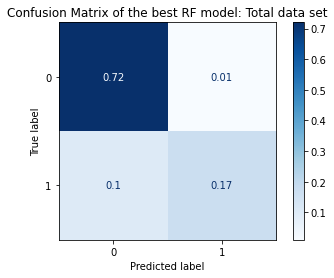

In [46]:
plot_confusion_matrix(best_rfc, X, y, normalize = 'all', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of the best RF model: Total data set')
plt.show()

[0.04417012 0.05623908 0.07585592 0.05788609 0.0544868  0.04886895
 0.06298857 0.03909428 0.00184639 0.05303484 0.00329735 0.04645343
 0.05265978 0.09447857 0.04438434 0.03585843 0.04953686 0.04976105
 0.06035907 0.06874009]


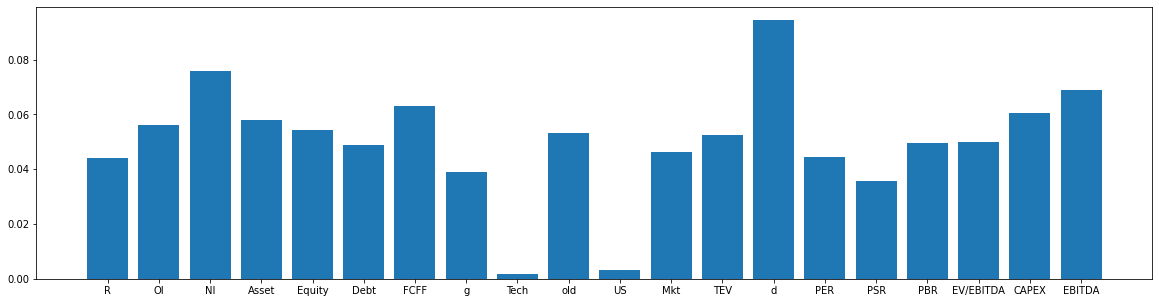

In [42]:
best_imp = best_rfc.feature_importances_

I = np.arange(imp.shape[0])
plt.subplots(1, figsize=(20, 5))
plt.bar(I,best_imp)
plt.xticks(I,features)
print(best_imp)

$\textbf{S&P 500 Data: Neural Network Prediction}$

In [49]:
X_n = MinMaxScaler().fit_transform(X)

In [50]:
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(7), max_iter=1000).fit(X_n, y)
clf.fit(X_n,y)

pred = clf.predict(X_n) # note, 1 is positive class
accuracy = accuracy_score(y,pred)

CM = confusion_matrix(y, pred, normalize='true')
true_positive = CM[1,1]
true_negative = CM[0,0]
false_positive = CM[0,1]
false_negative = CM[1,0]

accuracy

0.7461139896373057

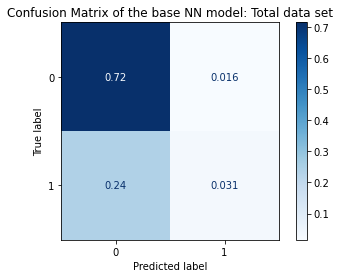

In [51]:
plot_confusion_matrix(clf, X_n, y, normalize = 'all', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of the base NN model: Total data set')
plt.show()

In [52]:
X_median = np.median(X_n, axis=0).reshape((1,-1)) # (1,D)
proba_median = clf.predict_proba(X_median)
proba_median.shape

(1, 2)

In [53]:
proba_median

array([[0.75472854, 0.24527146]])

[0.34216692 0.07594866 0.12912961 0.30363007 0.1668562  0.17690423
 0.03682038 0.12118878 0.19130264 0.09110428 0.04083602 0.18407613
 0.1863802  0.38522599 0.23524601 0.16475218 0.1501098  0.01290297
 0.25386958 0.08372149]


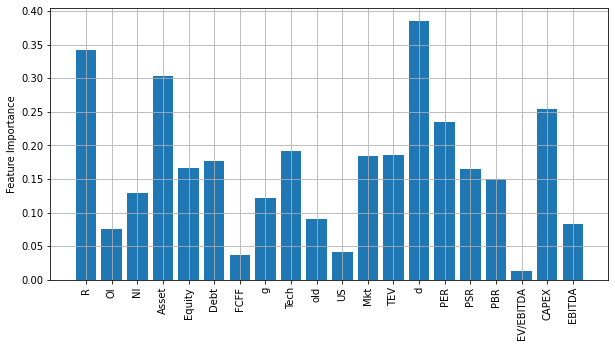

In [56]:
D = X.shape[1]
importance = []
for i in range(D):
    #print(x_median_i_perturbed)
    x_median_i_perturbed = X_median.copy()
    x_median_i_perturbed[0,i]+=0.00001
    
    proba_median_perturbed = clf.predict_proba(x_median_i_perturbed)
    imp = abs(proba_median_perturbed[:,1] - proba_median[:,1])/0.00001 
    importance.append(imp)
importance = np.array(importance).reshape(-1)
    
feature_indices = np.arange(len(importance))

plt.figure(figsize=(10, 5))
plt.bar(feature_indices,importance)
plt.xticks(feature_indices, snp.columns[1:-1], rotation='vertical')
plt.ylabel('Feature Importance')
plt.grid(True)

print(importance)

In [57]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y, test_size=0.3)
nn_clf = MLPClassifier(random_state=1, hidden_layer_sizes=(7), max_iter=1000)
nn_clf.fit(X_train_n, y_train_n)

MLPClassifier(hidden_layer_sizes=7, max_iter=1000, random_state=1)

In [60]:
hl_size = [i for i in range(200,251,1)]
max_it = [1000, 2000, 5000, 10000]

100%|██████████| 51/51 [05:37<00:00,  6.61s/it]


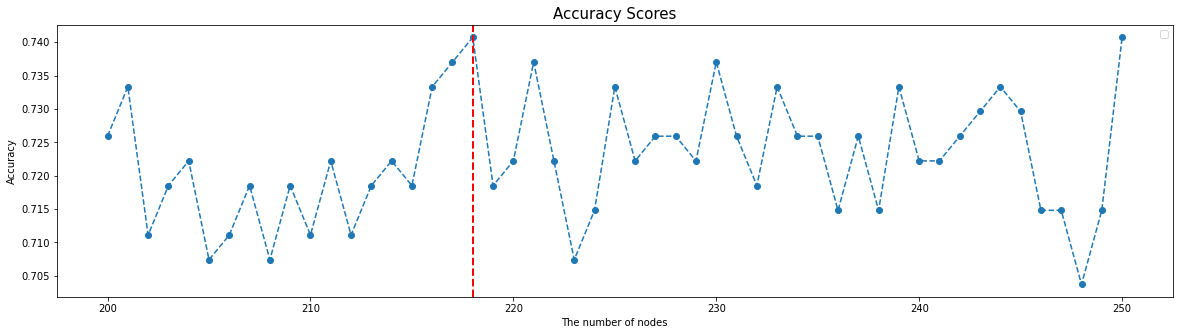

the performance is the best when the number of Hidden Layers is 19
The performance(10 fold cross validation)
Accuracy with Max_it 1000:  0.7407


100%|██████████| 51/51 [05:23<00:00,  6.34s/it]


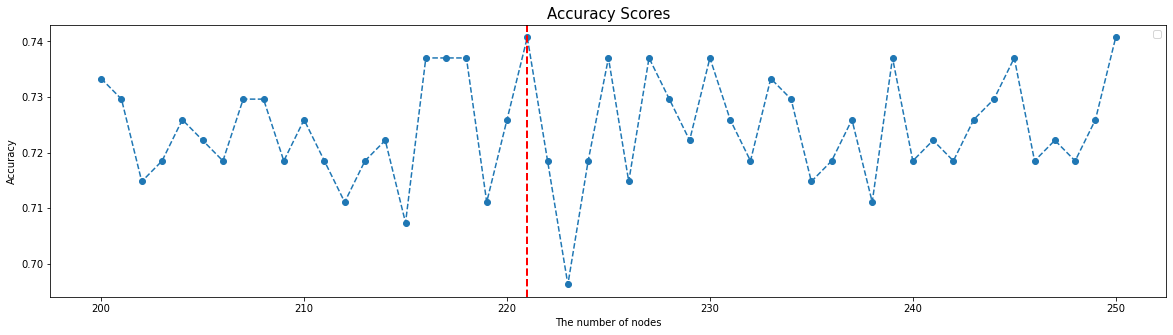

the performance is the best when the number of Hidden Layers is 22
The performance(10 fold cross validation)
Accuracy with Max_it 2000:  0.7407


100%|██████████| 51/51 [05:21<00:00,  6.31s/it]


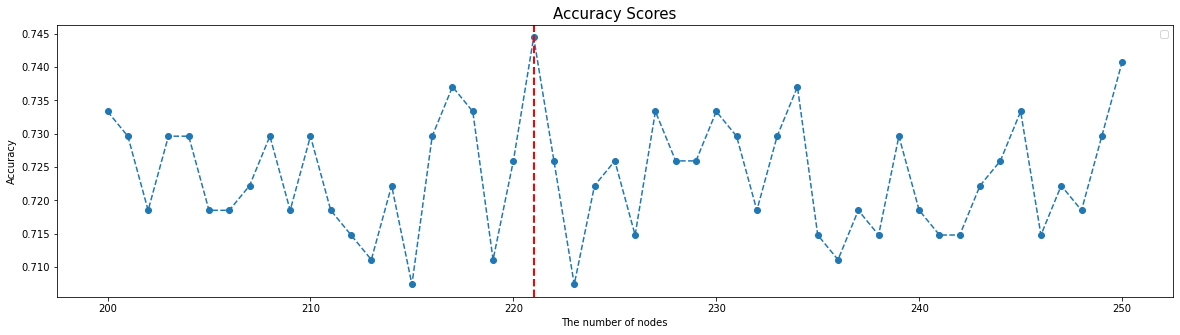

the performance is the best when the number of Hidden Layers is 22
The performance(10 fold cross validation)
Accuracy with Max_it 5000:  0.7444


100%|██████████| 51/51 [05:14<00:00,  6.16s/it]


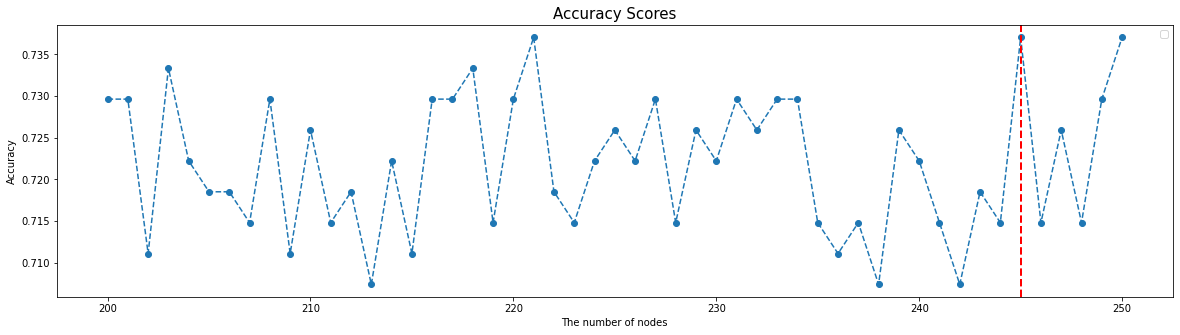

the performance is the best when the number of Hidden Layers is 46
The performance(10 fold cross validation)
Accuracy with Max_it 10000:  0.7370


In [61]:
cv_nn_scores = []

for j in range(0,len(max_it)):
    for i in tqdm(range(0,len(hl_size),1)):
        nn_clf = MLPClassifier(random_state=1, hidden_layer_sizes=hl_size[i], max_iter=hl_size[j]).fit(X_n, y)
        score = cross_val_score(nn_clf, X_train_n, y_train_n, cv=10, scoring = 'accuracy').mean()
        cv_nn_scores.append(score)
        best_e = [hl_size[k] for k in range(len(cv_nn_scores)) if cv_nn_scores[k] == np.max(cv_nn_scores)]
    
    # Show the results
    plt.figure(figsize = (20,5))
    plt.legend(["Cross validation scores"], fontsize = 10)
    plt.plot(hl_size, cv_nn_scores, marker = 'o', linestyle = 'dashed')
    plt.xlabel("The number of nodes", fontsize = 10)
    plt.ylabel("Accuracy", fontsize = 10)
    plt.title("Accuracy Scores", fontsize = 15)
    plt.axvline(best_e[0], color='r', linestyle = '--', linewidth=2)
    plt.show()
    
    # print out how much accurate the results and clean out
    print(f"the performance is the best when the number of Hidden Layers is {(cv_nn_scores.index(max(cv_nn_scores)))+1}")
    print("The performance(10 fold cross validation)")
    print(f"Accuracy with Max_it {max_it[j]}: {max(cv_nn_scores): 0.4f}")
    cv_nn_scores = []

In [62]:
best_nn = MLPClassifier(random_state=1, hidden_layer_sizes=(222), max_iter=5000)
best_nn.fit(X_train_n, y_train_n)

MLPClassifier(hidden_layer_sizes=222, max_iter=5000, random_state=1)

In [63]:
# Accuracy based on Training set
y_pred_n = best_nn.predict(X_train_n)
acc_n = accuracy_score(y_true = y_train_n, y_pred = y_pred_n)
print("The performance of the best NN model to train set")
print(f"accuracy: {acc_n:0.4f}")

# Accuracy based on Test set
y_pred_n = best_nn.predict(X_test_n)
acc_n = accuracy_score(y_true = y_test_n, y_pred = y_pred_n)
print("The performance of the best NN model to test set")
print(f"accuracy: {acc_n:0.4f}")

# Accuracy based on total dataset
y_pred_n = best_nn.predict(X_n)
acc_n = accuracy_score(y_true = y, y_pred = y_pred_n)
print("The performance of the best NN model to total data set")
print(f"accuracy: {acc_n:0.4f}")

The performance of the best NN model to train set
accuracy: 0.8074
The performance of the best NN model to test set
accuracy: 0.7845
The performance of the best NN model to total data set
accuracy: 0.8005


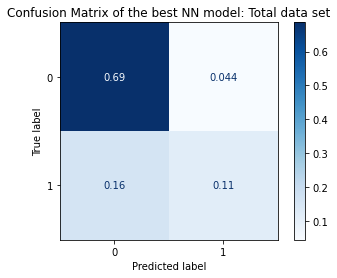

In [64]:
plot_confusion_matrix(best_nn, X_n, y, normalize = 'all', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of the best NN model: Total data set')
plt.show()

In [65]:
X_median = np.median(X_n, axis=0).reshape((1,-1)) # (1,D)
proba_median = best_nn.predict_proba(X_median)
proba_median.shape

(1, 2)

In [66]:
proba_median

array([[0.69116442, 0.30883558]])

[6356.06935427 6356.33557252 6356.54065079 6356.10789111 6356.24466499
 6356.23461695 6356.44834156 6356.53270997 6356.60282383 6356.3204169
 6356.4523572  6356.22744505 6356.22514098 6356.02629519 6356.6467672
 6356.57627337 6356.26141139 6356.39861821 6356.1576516  6356.3277997 ]


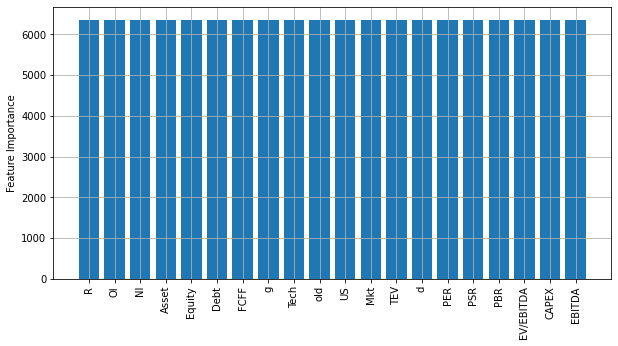

In [68]:
D = X.shape[1]
importance = []
for i in range(D):
    #print(x_median_i_perturbed)
    x_median_i_perturbed = X_median.copy()
    x_median_i_perturbed[0,i]+=0.00001
    
    proba_median_perturbed = clf.predict_proba(x_median_i_perturbed)
    imp = abs(proba_median_perturbed[:,1] - proba_median[:,1])/0.00001 
    importance.append(imp)
importance = np.array(importance).reshape(-1)
    
feature_indices = np.arange(len(importance))

plt.figure(figsize=(10, 5))
plt.bar(feature_indices,importance)
plt.xticks(feature_indices, snp.columns[1:-1], rotation='vertical')
plt.ylabel('Feature Importance')
plt.grid(True)

print(importance)

In [70]:
snp2021=pd.read_csv('2021final01.csv')
snp2021.head()

,Name,R,OI,NI,Asset,Equity,Debt,FCFF,g,Tech,...,Mkt,TEV,d,PER,PSR,PBR,EV/EBITDA,CAPEX,EBITDA,Survival
0,LyondellBasell Industries NV,27753.0,2181.0,1420.0,35403.0,8104.0,17832.0,-61.000,-15.6471,0,...,29920.60441,43379.60441,5.0272,21.070848,1.078103,0.845143,12.472572,1947.0,3478.0,1
1,Verizon Communications Inc,134238.0,33943.0,22040.0,353457.0,78489.0,178985.0,-24466.875,-0.9872,0,...,210686.27000,380963.27000,5.1006,9.559268,1.569498,0.596073,7.917107,18192.0,48119.0,1
2,Broadcom Inc,26510.0,7646.0,6071.0,75880.0,24367.0,40457.0,11894.375,7.0428,1,...,260009.77680,289388.77680,2.5962,42.828163,9.807989,3.426592,25.942517,463.0,11155.0,1
3,Boeing Co/The,62797.0,-3517.0,-8479.0,146846.0,-14266.0,62419.0,-2700.500,-24.1648,0,...,120513.60290,163111.60290,0.0000,-14.213186,1.919098,0.820680,-25.434524,1303.0,-6413.0,1
4,Caterpillar Inc,48408.0,6984.0,5149.0,80784.0,16695.0,36792.0,3257.750,-12.6553,0,...,110059.97790,138327.97790,2.1822,21.375020,2.273591,1.362398,18.964625,2115.0,7294.0,1


In [72]:
X21 = snp2021.iloc[:,1:-1]
y_pred21 = best_rfc.predict(X21)
print(y_pred21)

[1 1 1 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1
 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0]


In [76]:
y_pred_n21 = best_nn.predict(X21)
print(y_pred_n21)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1]
